In [1]:
import os
import glob
import json
import pymworks
import re
import datautils
import copy
import math
import time

import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import cPickle as pkl
from cPickle import PicklingError

import scipy.stats as spstats
import utils as util
import process_datafiles as processd

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/datautils/__init__.py:22: UserWarning: datautils.mongo failed to import with: No module named pymongo
  warnings.warn('datautils.mongo failed to import with: %s' % E)
utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/e

# Set root and meta

In [2]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

metadata = util.get_metadata(paradigm, rootdir=rootdir, create_meta=False)


Loading existing metadata...


# Load 1 animal

#### Find correct sessions

In [3]:
phase = 2

cohort='AL'
glob.glob(os.path.join(rootdir, paradigm, 'by_phase', '%s*' % cohort, '%i_*' % phase, '%s*' % cohort, '*.mwk'))

['/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL13/AL13_170907.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL13/AL13_170908.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL13/AL13_170909.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL13/AL13_170911.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL14/AL14_170814.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL14/AL14_170815.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL15/AL15_170815b.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL15/AL15_170816.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL15/AL15_170816b.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL15/AL15_170817.mwk',
 '/n/coxfs01/behavior-data/threeport/by_phase/AL13 - AL16/2_size/AL16/AL16_170814.mwk',
 '/n/coxfs01/behavior-data/thr

In [4]:
animalid = 'AG2'

sorted_dfns = glob.glob(os.path.join(rootdir, paradigm, 'by_phase', '%s*' % cohort, '%i_*' % phase, '%s*' % cohort, '%s_*.mwk' % animalid))
print("%i datafiles for phase %i" % (len(sorted_dfns), phase))
included_sessions = sorted(list(set([util.parse_datafile_name(dfn)[1] for dfn in sorted_dfns])), key=natural_keys)
included_sessions


0 datafiles for phase 2


[]

In [80]:
animalid = 'AM1'

In [81]:
#### Get dataframe
training_flag_names = ['FlagAlwaysReward', #
                       'FlagStaircaseSize',
                       'FlagStaircaseDeptRotLeft', #
                       'FlagStaircaseDeptRotRight', 
                       'FlagShowOnlyTrainedAxes']

# ignore_keys = ['file_hash', 'filename', 'type']

df, new_s = processd.get_animal_df(animalid, paradigm, metadata, create_new=False, rootdir=rootdir)
df['object'] = [re.findall('(\d{1})', re.search('Blob(\D+\d{1})', imname).group(0).split('_')[1])[0]\
                if 'morph' not in imname else 'morph' 
                for imname in df['name']]

/n/coxfs01/behavior-data/threeport/processed/data
/n/coxfs01/behavior-data/threeport/processed/data/df_AM1.pkl
... loading existing df


In [82]:
df.head()

,FlagAlwaysReward,FlagShowOnlyTrainedAxes,FlagStaircaseDeptRotLeft,FlagStaircaseDeptRotRight,FlagStaircaseSize,action,depth_rotation,duration,name,no_feedback,...,pos_y,response,response_time,rotation,size,size_x,size_y,time,session,object
0,0,1,0,0,0,draw,0,1049654,Blob_1_RotDep_0,False,...,0.0,Announce_AcquirePort3,1.020681,0.0,40.0,69.879997,69.879997,1733993556788,20181002,1
1,0,1,0,0,0,draw,0,783076,Blob_2_RotDep_0,False,...,0.0,Announce_AcquirePort1,0.758423,0.0,40.0,69.879997,69.879997,1733997755407,20181002,2
2,0,1,0,0,0,draw,0,5148306,Blob_1_RotDep_0,False,...,0.0,Announce_AcquirePort1,0.564290,0.0,40.0,69.879997,69.879997,1734041757597,20181002,1
3,0,1,0,0,0,draw,0,1516169,Blob_1_RotDep_0,False,...,0.0,Announce_AcquirePort3,1.497788,0.0,40.0,69.879997,69.879997,1734050488058,20181002,1
4,0,1,0,0,0,draw,0,799737,Blob_2_RotDep_0,False,...,0.0,Announce_AcquirePort1,0.768765,0.0,40.0,69.879997,69.879997,1734055153191,20181002,2


In [83]:
sorted(df[(df['FlagStaircaseSize']==1)]['session'].unique())


[20171106, 20171107, 20171108, 20171109, 20171110]

In [84]:
sorted(df[(df['FlagStaircaseDeptRotRight']==1) 
         & (df['FlagStaircaseSize']==0)]['session'].unique())


[20171111]

In [85]:
df[(df['FlagStaircaseDeptRotLeft']==1)
  & (df['FlagStaircaseSize']==0)]['session'].unique()

array([], dtype=int64)

In [86]:
[f for f in df.columns if 'Flag' in f]

['FlagAlwaysReward',
 'FlagShowOnlyTrainedAxes',
 'FlagStaircaseDeptRotLeft',
 'FlagStaircaseDeptRotRight',
 'FlagStaircaseSize']

In [87]:
animalid = 'AM1'
print(animalid)
A, new_sessions = util.load_animal_data(animalid, paradigm, metadata, rootdir=rootdir)


AM1
(False, False)
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AM/processed/data/AM1.pkl
[AM1]: Loaded 95 processed sessions (+0 are None).
[AM1]: Found 0 out of 95 sessions to process.


In [88]:
A.sessions[20180404].flags

{'FlagAddFreeRewardToEarnedReward': [0],
 'FlagAlwaysEnforceMaxSeqLeng': [1],
 'FlagAlwaysReward': [0],
 'FlagAutomaticBiasSuppression': [0],
 'FlagBackgroundTransparency': [1],
 'FlagCorrectionTrials': [0],
 'FlagCueStimSound': [0],
 'FlagDiffBackground': [0],
 'FlagDiscardHalfOfTheTrials': [1],
 'FlagEnrichSomeStaircases': [0],
 'FlagForceCueStimSoundOff': [0],
 'FlagLongPunishment': [1],
 'FlagPlayOutcomeSound': [1],
 'FlagRepeatedTrial': [0],
 'FlagSampUniformDistr': [0],
 'FlagShowOnlyTrainedAxes': [1],
 'FlagShowStimAfterResponse': [1],
 'FlagShowStimLeft': [1],
 'FlagShowStimRight': [1],
 'FlagShowVisualStimuli': [1],
 'FlagStaircaseDeptRotLeft': [-1],
 'FlagStaircaseDeptRotRight': [1],
 'FlagStaircaseHorizSeparation': [1],
 'FlagStaircasePosHL': [0],
 'FlagStaircasePosHR': [0],
 'FlagStaircasePosVD': [0],
 'FlagStaircasePosVU': [0],
 'FlagStaircaseProbFreeRew': [1],
 'FlagStaircaseRotACW': [1],
 'FlagStaircaseRotCW': [1],
 'FlagStaircaseSize': [-1],
 'run_bounds': [(1340999801,

In [92]:
sorted(df[df['session']==20180404]['depth_rotation'].unique())



[-60, -45, -30, -15, 0, 15, 30, 45, 60]

In [77]:
A.sessions[20180404].trials[0]

{'action': 'draw',
 'depth_rotation': 0,
 'duration': 5281597,
 'file_hash': 'e4fe0fee92cb9f18b1cbc2eb5a6453d675a59084',
 'filename': '/var/folders/nb/yv6_dvnd3zz5ddtkty_drsb00000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs_lean_diffbackground_transparency/tmp/Blobs_TrainingRatsD1D2_NoBackground/Blob_N2_CamRot_y0.png',
 'name': 'Blob_N2_CamRot_y0',
 'no_feedback': False,
 'outcome': 'success',
 'outcome_time': 1402602795,
 'pos_x': 0.0,
 'pos_y': 0.0,
 'response': 'Announce_AcquirePort3',
 'response_time': 1402602458,
 'rotation': 0.0,
 'size': 25.0,
 'size_x': 43.67499923706055,
 'size_y': 43.67499923706055,
 'time': 1401908220,
 'type': 'image'}

In [73]:
os.path.split(A.sessions[20150220].experiment_path[0])


('/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache',
 '_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs')

In [25]:
currdf = df[ (df['FlagAlwaysReward'].isin([0, -1]))]
x1 = sorted(currdf['session'].unique())


In [26]:
currdf = df[ (df['FlagAlwaysReward']==0)]
x2 = sorted(currdf['session'].unique())


In [27]:
x1==x2

True

In [37]:
phase=3
if phase == 2:
    currdf = df[((df['FlagStaircaseDeptRotRight']==0) | (df['FlagStaircaseDeptRotLeft']==0))
                & (df['FlagStaircaseSize']==1)
                & (df['FlagAlwaysReward'].isin([0, -1]))]
elif phase == 3:
    currdf = df[((df['FlagStaircaseDeptRotRight']==1) | (df['FlagStaircaseDeptRotLeft']==1))
                & (df['FlagStaircaseSize']==0)
                & (df['FlagAlwaysReward'].isin([0, -1]))]

In [38]:
print("Phase: %i" % phase)
currdf['session'].unique()

Phase: 3


array([20171111])

In [28]:
dfn = '/n/coxfs01/behavior-data/threeport/by_cohort/AG_Cohort/AG phase3/AG2/AG2_150501.mwk'
df = pymworks.open(dfn)


here


In [426]:
import pprint

In [427]:
pp = pprint.PrettyPrinter(indent=4)

In [59]:
# sessionlist = {'size': [], 'depth_rotation': [], 'trained_axes': []}
# for s, v in A.sessions.items():
#     if s in always_reward_sessions:
#         print "skipping %s" % s
#         continue
#     else:
#         #if any([v.flags[k]==1 for k in tflags]):
#         #    sessionlist.append(s)
#         if v.flags['FlagStaircaseSize'] in [1]: #, -1]:
#             sessionlist['size'].append(s)
#         if v.flags['FlagStaircaseDeptRotLeft'] in [1] or v.flags['FlagStaircaseDeptRotRight'] in [1]:
#             sessionlist['depth_rotation'].append(s)
#         if v.flags['FlagShowOnlyTrainedAxes']==1:
#             sessionlist['trained_axes'].append(s)

# T1 = 'size'
# T2 = 'depth_rotation'
# print(len(sessionlist[T1]))
# print(len(sessionlist[T2]))

# #len(np.union1d(sessionlist[T1], sessionlist[T2] ) )
# len(np.intersect1d(sessionlist[T1], sessionlist[T2] ) )   

In [60]:
sessionlist[T1]

NameError: name 'sessionlist' is not defined

In [61]:
sessionlist[T2]

NameError: name 'sessionlist' is not defined

In [383]:
sessionlist

{'depth_rotation': [20170719], 'size': [20170719], 'trained_axes': [20170719]}

In [384]:
for s in included_sessions:
    print [(s, k, A.sessions[int(s)].flags[k]) for k in training_flags]

[('20170817', 'FlagStaircaseDeptRotRight', 0), ('20170817', 'FlagStaircaseDeptRotLeft', 0), ('20170817', 'FlagAlwaysReward', 0), ('20170817', 'FlagShowOnlyTrainedAxes', 1), ('20170817', 'FlagStaircaseSize', 1)]
[('20170822', 'FlagStaircaseDeptRotRight', 0), ('20170822', 'FlagStaircaseDeptRotLeft', 0), ('20170822', 'FlagAlwaysReward', 0), ('20170822', 'FlagShowOnlyTrainedAxes', 1), ('20170822', 'FlagStaircaseSize', 1)]
[('20170823', 'FlagStaircaseDeptRotRight', 0), ('20170823', 'FlagStaircaseDeptRotLeft', 0), ('20170823', 'FlagAlwaysReward', 0), ('20170823', 'FlagShowOnlyTrainedAxes', 1), ('20170823', 'FlagStaircaseSize', 1)]
[('20170907', 'FlagStaircaseDeptRotRight', 0), ('20170907', 'FlagStaircaseDeptRotLeft', 0), ('20170907', 'FlagAlwaysReward', 0), ('20170907', 'FlagShowOnlyTrainedAxes', 1), ('20170907', 'FlagStaircaseSize', 1)]
[('20170908', 'FlagStaircaseDeptRotRight', 0), ('20170908', 'FlagStaircaseDeptRotLeft', 0), ('20170908', 'FlagAlwaysReward', 0), ('20170908', 'FlagShowOnlyT

False

In [419]:
#currdf = df[df['session'].isin(included_sessions)].copy()
currdf = df[df['session'].isin(sessionlist[T1])].copy()

currdf.shape


(2277, 15)

#### Group by features

In [62]:
odf=currdf.copy() #currdf[(currdf['object']=='1')].copy()

features = ['depth_rotation', 'size', 'rotation', 'object', 'response_time', 'outcome', 'session']
odf = odf[features]

In [63]:
planar_rots = sorted(odf['rotation'].unique())
depth_rots = sorted(odf['depth_rotation'].unique())
print("N in-plane: %i" % len(planar_rots))
print("N in-depth: %i" % len(depth_rots))


N in-plane: 1
N in-depth: 1


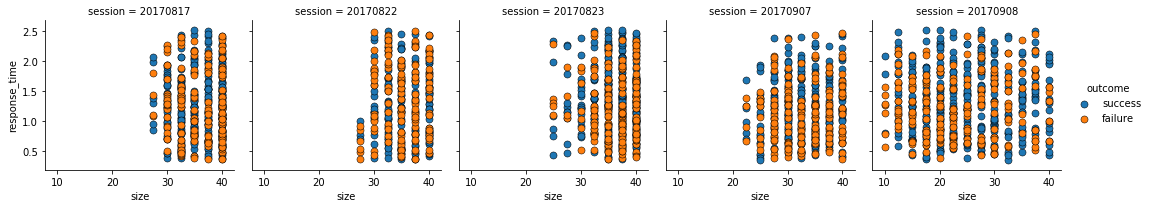

In [64]:
# For size
kws = dict(s=50, linewidth=.5, edgecolor="k")
g = sns.FacetGrid(odf, col='session', hue='outcome')
g = (g.map(pl.scatter, 'size', "response_time", **kws)
     .add_legend())


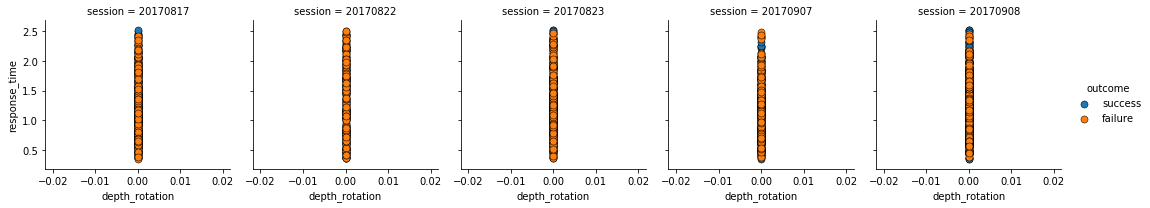

In [65]:
# For size
kws = dict(s=50, linewidth=.5, edgecolor="k")
g = sns.FacetGrid(odf, col='session', hue='outcome')
g = (g.map(pl.scatter, 'depth_rotation', "response_time", **kws)
     .add_legend())


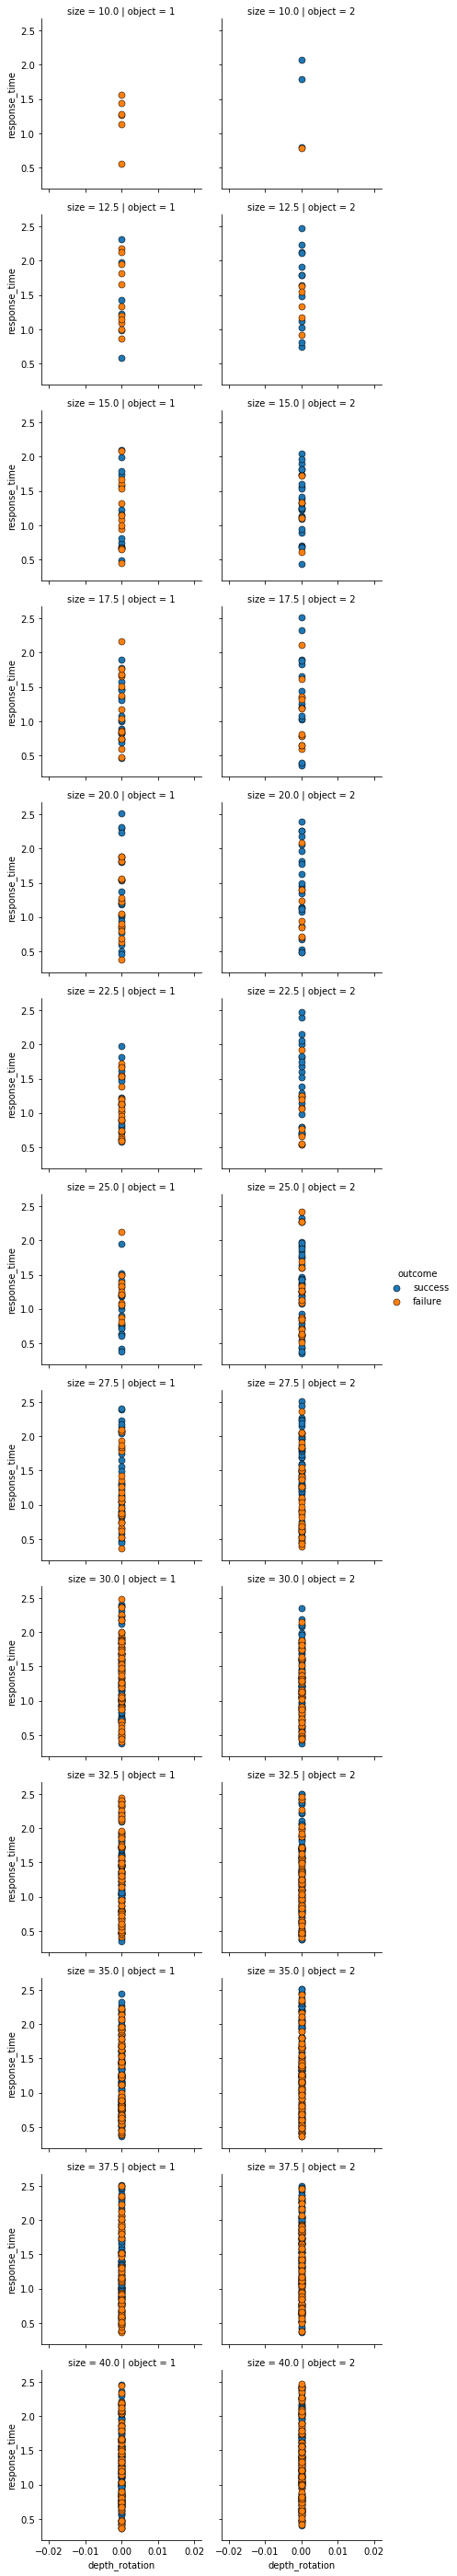

In [66]:
# For ROTATION

kws = dict(s=50, linewidth=.5, edgecolor="k")
g = sns.FacetGrid(odf, row='size', col='object', hue='outcome')
g = (g.map(pl.scatter, 'depth_rotation', "response_time", **kws)
     .add_legend())


#### visualize better

In [67]:
currdf['abs_depth_rotation'] = np.abs(currdf['depth_rotation'])
currdf['abs_planar_rotation'] = np.abs(currdf['rotation'])

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<Figure size 432x288 with 0 Axes>

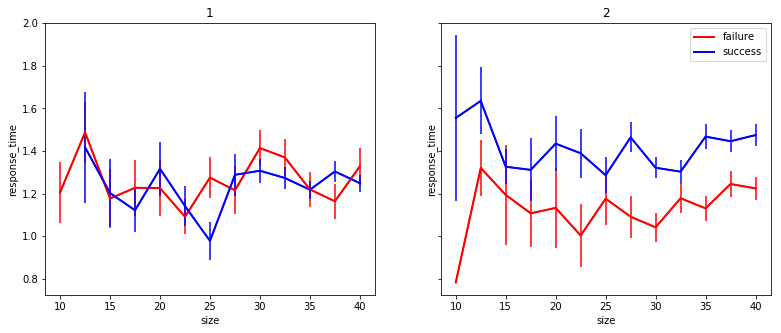

In [70]:
colors = {'success': 'b',
          'failure': 'r'}


pl.suptitle('Mean')

curr_feature = 'size'
metric = 'response_time'

fig, axes = pl.subplots(1, 2, figsize=(13,5), sharex=True, sharey=True)
i=0
for obj, tmpd in currdf.groupby(['object']):
    ax = axes[i]
    for outcome, tmpd_by_outcome in tmpd.groupby(['outcome']):

        yv = [g[metric].values for r, g in tmpd_by_outcome.groupby([curr_feature])]
        xv = [np.array([r for _ in np.arange(len(g))]) for r, g in tmpd_by_outcome.groupby([curr_feature])]

        mean_xs = [np.mean(x) for x in xv]
        mean_ys = [np.mean(y) for y in yv]
        sem_ys = [spstats.sem(y) for y in yv]
        
        ax.plot(mean_xs, mean_ys, color=colors[outcome], lw=2, label=outcome)
        ax.errorbar(mean_xs, mean_ys, yerr=sem_ys, color=colors[outcome])

        xvp = np.concatenate(xv).ravel()
        yvp = np.concatenate(yv).ravel()
        #ax.scatter(xvp, yvp, c=colors[outcome], s=10, alpha=0.1)
        
        ax.set_title(obj)
        ax.set_ylabel(metric)
        ax.set_xlabel(curr_feature)

    i += 1
    
#     sns.scatterplot(x='depth_rotation', y='response_time', hue='outcome', data=odf, ax=ax, 
#                 palette='colorblind', alpha=0.7)
ax.legend()

Text(0.5,0.98,'Variance')

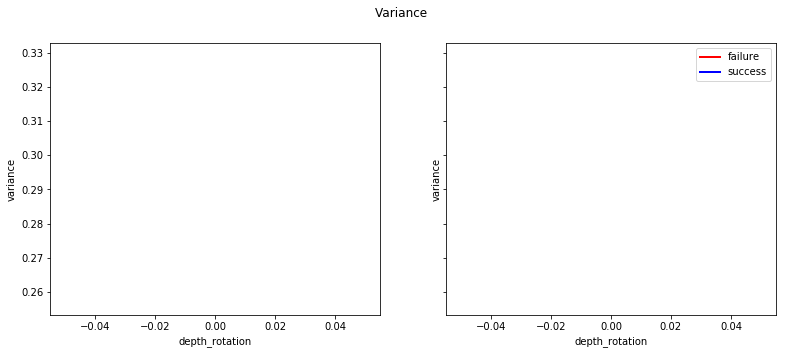

In [71]:
colors = {'success': 'b',
          'failure': 'r'}

curr_feature = 'depth_rotation'
metric = 'variance'

fig, axes = pl.subplots(1, 2, figsize=(13,5), sharex=True, sharey=True)
i=0
for obj, tmpd in currdf.groupby(['object']):
    ax = axes[i]
    for outcome, tmpd_by_outcome in tmpd.groupby(['outcome']):
        
        yv = [g['response_time'].values for r, g in tmpd_by_outcome.groupby([curr_feature])]
        xv = [np.array([r for _ in np.arange(len(g))]) for r, g in tmpd_by_outcome.groupby([curr_feature])]

        feature_values = [np.mean(x) for x in xv]
        response_values = [np.mean(y) for y in yv]
        
        response_values_var = [np.std(y)**2 for y in yv]
        response_sem = spstats.sem(response_values_var)
        ax.plot(feature_values, response_values_var, color=colors[outcome], lw=2, label=outcome)
        ax.errorbar(feature_values, response_values_var, yerr=response_sem, color=colors[outcome])

        xvp = np.concatenate(xv).ravel()
        yvp = np.concatenate(yv).ravel()
        #ax.scatter(xvp, yvp, c=colors[outcome], s=10, alpha=0.1)

        ax.set_ylabel(metric)
        ax.set_xlabel(curr_feature)
    i += 1
ax.legend()

pl.suptitle('Variance')

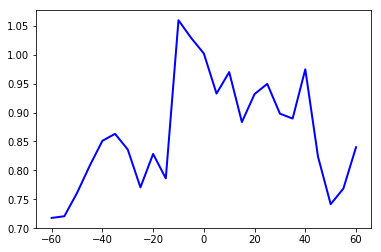

In [20]:
pl.figure()
pl.plot(mean_xs, mean_ys, color=colors[outcome], lw=2)


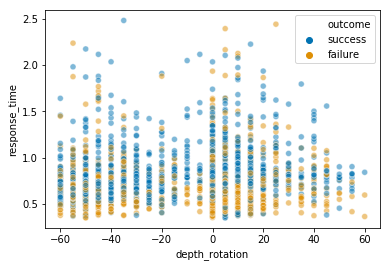

In [21]:
fig, ax = pl.subplots()
sns.scatterplot(x='depth_rotation', y='response_time', hue='outcome', data=currdf[currdf['object']=='2'], ax=ax, 
                palette='colorblind', alpha=0.5)


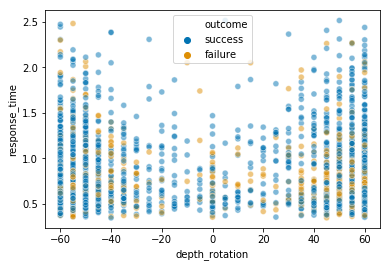

In [320]:
fig, ax = pl.subplots()
sns.scatterplot(x='depth_rotation', y='response_time', hue='outcome', data=currdf[currdf['object']=='2'], ax=ax, 
                palette='colorblind', alpha=0.5)


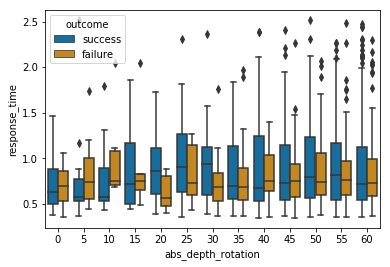

In [326]:
fig, ax = pl.subplots()
sns.boxplot(x='abs_depth_rotation', y='response_time', hue='outcome', data=currdf[currdf['object']=='2'], ax=ax, 
                palette='colorblind') #, alpha=0.7)


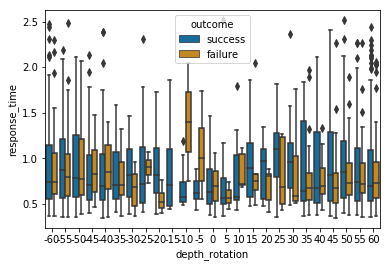

In [327]:
fig, ax = pl.subplots()
sns.boxplot(x='depth_rotation', y='response_time', hue='outcome', data=currdf[currdf['object']=='2'], ax=ax, 
                palette='colorblind') #, alpha=0.7)


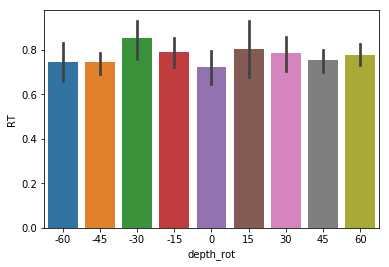

In [111]:
fig, ax = pl.subplots()
sns.barplot(x='depth_rot', y='RT', data=tmpd[tmpd['plane_rot']==0], ax=ax)
